# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [6]:
# dataDir ="C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/location-2"
dataDir = "D:/desktop_alternative/buetav/behavior-hypotheses-main/location-2"
# dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "C:/Users/Zenbook325E/Downloads/csv"
# dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [7]:
# exec(open('C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())
exec(open('D:/desktop_alternative/buetav/behavior-hypotheses-main/src/notebooks/init_notebook.py').read())
# exec(open('init_notebook.py').read())

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import sys

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
sys.path.append(os.path.abspath('C:/Users/ASUS/Desktop/buetav/behavior-hypotheses-main/src'))
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [10]:
sceneId = 240
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [11]:
pedDf.head(5)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration
0,18,3208,18061,240,6.0,-0.026381,2.882353,0.171520,0.800383,-0.045989,0.044870
1,18,3210,18061,240,6.0,-0.063628,2.724335,0.186239,0.790090,-0.073597,0.051462
2,18,3212,18061,240,6.0,-0.103918,2.568007,0.201445,0.781639,-0.076030,0.042259
3,18,3214,18061,240,6.0,-0.147248,2.413341,0.216651,0.773328,-0.076027,0.041552
4,18,3216,18061,240,6.0,-0.193228,2.259880,0.229901,0.767307,-0.066252,0.030105


In [12]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        fps=fps,
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        # xAccCol='sceneXAcceleration',
        # yAccCol='sceneYAcceleration',
        speedCol='speed',
        # accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    # minAcceleration = 0.0,
    # maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
# transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

In [13]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

# visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate180(trackDf=trackDf, xCol='localX', yCol='localY')
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


using min Y displacement (5)


9062

### Right side of the vertical axis is negative

In [14]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,localX,localY
0,18,3208,18061,240,6.0,-0.026381,2.882353,0.171520,0.800383,-0.045989,0.044870,0.818555,0.000000,0.000000,-0.000000,-0.000000
1,18,3210,18061,240,6.0,-0.063628,2.724335,0.186239,0.790090,-0.073597,0.051462,0.811744,0.037248,0.158018,0.037248,0.158018
2,18,3212,18061,240,6.0,-0.103918,2.568007,0.201445,0.781639,-0.076030,0.042259,0.807180,0.077537,0.314346,0.077537,0.314346
3,18,3214,18061,240,6.0,-0.147248,2.413341,0.216651,0.773328,-0.076027,0.041552,0.803103,0.120867,0.469012,0.120867,0.469012
4,18,3216,18061,240,6.0,-0.193228,2.259880,0.229901,0.767307,-0.066252,0.030105,0.801009,0.166847,0.622473,0.166847,0.622473
5,18,3218,18061,240,6.0,-0.240504,2.109984,0.236381,0.749482,-0.032401,0.089126,0.785875,0.214124,0.772369,0.214124,0.772369
6,18,3220,18061,240,6.0,-0.288179,1.963819,0.238375,0.730823,-0.009969,0.093294,0.768717,0.261799,0.918534,0.261799,0.918534
43,18,7675,18128,240,6.0,2.224438,-2.947820,0.007532,-0.343022,0.023814,0.011245,0.343105,0.000000,0.000000,0.000000,0.000000
44,18,7677,18128,240,6.0,2.222974,-2.879315,0.007317,-0.342528,0.001072,-0.002470,0.342606,0.001463,0.068506,-0.001463,0.068506
45,18,7679,18128,240,6.0,2.221188,-2.809842,0.008930,-0.347365,-0.008065,0.024182,0.347479,0.003250,0.137979,-0.003250,0.137979


In [15]:
# plt.boxplot(startingDf["speed"])

In [16]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

In [17]:
# starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
# visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# # starting023.size
# starting023

In [18]:
# starting023 = AngularDisplacementCalculator.addAngularDisplacement(starting023)
# starting023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
# starting023

In [19]:
NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

In [20]:
def find_RankA(arr):
    new_arr = np.empty_like(arr)
    for row in arr:
        new_arr[0] = arr[2]
        new_arr[2] = arr[0]
        # new_arr[row[:arr[0]].tolist().index(1)] = row
    return new_arr

In [21]:
def AngDisVsMaxSpeed(dataframe):
    
    total_length = len(dataframe)
    newAngularDisplacementDf = AngularDisplacementCalculator.getPedAngularDisplacementDf(dataframe)
    col1 = 'maxRelativeAngularDisplacement'
    col2 = 'maxSpeed'

    newAngularDisplacementDf['category1'] = assign_category(newAngularDisplacementDf[col1], NO_OF_CATEGORY)
    newAngularDisplacementDf['category2'] = assign_category(newAngularDisplacementDf[col2], NO_OF_CATEGORY)

    heatmapDf = pd.DataFrame(columns = [col1, col2, 'count'])
    heatmapDf['maxRelativeAngularDisplacement'] = newAngularDisplacementDf['category1']
    heatmapDf['maxSpeed'] = newAngularDisplacementDf['category2']
    heatmapDf['count'] = 1
    heatmapDf = heatmapDf.groupby(['maxRelativeAngularDisplacement', 'maxSpeed']).count().reset_index()
    
    heatmapDf = heatmapDf.pivot(index='maxRelativeAngularDisplacement', columns='maxSpeed', values='count')

    # heatmapDf_swap = find_RankA(heatmapDf)
    df = heatmapDf.iloc[::-1]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df/total_length, annot=True, fmt=".6f", cmap='YlGnBu')
    
    x_labels = ["low", "medium", "high"]
    y_labels = ["high", "medium", "low"]
    
    count = 3
    
    plt.xticks(np.arange(0.5, count+0.5, 1), x_labels)
    plt.yticks(np.arange(0.5, count+0.5, 1), y_labels)

    plt.xlabel("maxSpeed")
    plt.ylabel("maxAngularSpeed")

    plt.show()



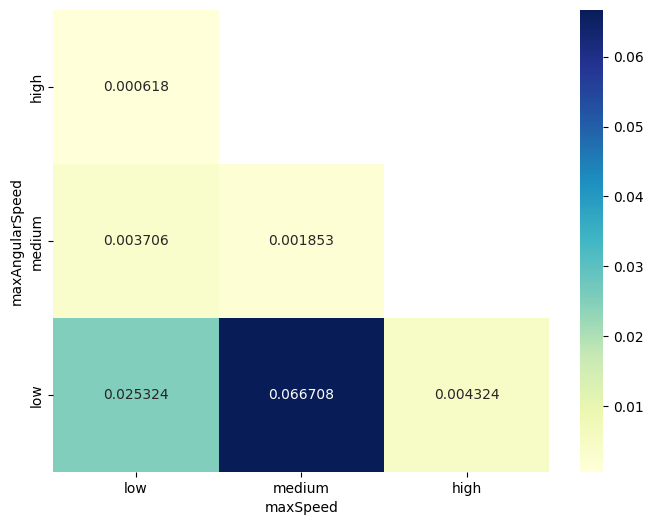

In [22]:
AngDisVsMaxSpeed(startingDf)